#IMPORTING LIBRARIES & FUNCTIONS

In [ ]:
import os
import cv2
import random
import matplotlib
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import backend as k
from google.colab import drive
import matplotlib.pyplot as plt
from numpy import zeros, newaxis
from IPython.display import Image, display
import matplotlib.cm as cm
from matplotlib.pyplot import imshow
from google.colab.patches import cv2_imshow
from tensorflow import GradientTape
from tensorflow.keras.backend import gradients
from tensorflow.keras import utils, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, Input, AveragePooling2D

In [ ]:
def preprocessing_fun(filename):
    desired_size = 224
    #print('',filename)
    #img = cv2.imread(filename)
    img = filename
    old_size = np.shape(img)
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    img= cv2.resize(img, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return img

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, alpha=0.4):#cam_path="cam.jpg"
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    #img = preprocessing_fun(img)
    print('',img.shape)
    for ii in range(1,50):
      if min(img[:,img.shape[1]-1,0]) > 200:
        img = img[0:img.shape[0],0:img.shape[1]-1]
      if min(img[:,1,0]) >200:
        img = img[0:img.shape[0],1:img.shape[1]]
      if min(img[img.shape[0]-1,:,0]) > 200:
        img = img[0:img.shape[0]-1,0:img.shape[1]]
      if min(img[1,:,0]) >200:
        img = img[1:img.shape[0],0:img.shape[1]]
    print('',img.shape)

    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("gist_gray")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img1 = cv2.cvtColor(np.array(superimposed_img), cv2.COLOR_BGR2GRAY)
    #plt.imshow(superimposed_img1,cmap='gray')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return superimposed_img1,img

def cropped_best_image(img_with_hm,img,box_size):
  #box_size=[150,150]
  sums1=[]
  for ii in range(np.shape(img)[0]-box_size[0]):
    for jj in range(np.shape(img)[1]-box_size[1]):
      sum=0
      for xx in range(box_size[0]):
        for yy in range(box_size[1]):
          if img_with_hm[ii+xx,jj+yy] > 235:
            sum = sum + img_with_hm[ii+xx,jj+yy]
      sums1.append([sum,ii,jj])
  sums1 = np.array(sums1)
  arg = np.argmax(sums1[:,0])
  imax = sums1[arg,1]
  jmax = sums1[arg,2]
  imgfinal = img[imax:imax+box_size[0],jmax:jmax+box_size[1]]
  return imgfinal

# PREPARE DATASET

In [ ]:
mount_point = '/content/drive'
drive.mount(mountpoint=mount_point)

Mounted at /content/drive


In [ ]:
# share a common dataset folder & add link to your drive.

dataset_path = "/content/drive/MyDrive/Dataset/Dataset.zip"
data_p2 = "/content/drive/MyDrive/Dataset/data1.zip"

assert os.path.exists(dataset_path), "zip file not found"

In [ ]:
!unzip -q /content/drive/MyDrive/Dataset/Dataset.zip
!unzip -q /content/drive/MyDrive/Dataset/data1.zip

In [ ]:
img_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function = preprocessing_fun)

traindata = img_datagen.flow_from_directory(directory="/content/Dataset", target_size=(224,224),
                          color_mode='rgb',batch_size=5, shuffle=True)

testdata = img_datagen.flow_from_directory(directory="/content/data1", target_size=(224,224),
                          color_mode='rgb',batch_size=5, shuffle=True)

Found 8000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.


# MODELS

EXPERIMENTAL

In [ ]:
model = Sequential([
                    Conv2D(25, 3, padding='same', activation='relu',kernel_initializer='he_uniform', input_shape = [256, 256,1]),
                    Conv2D(40, 3, activation='relu', strides=(2,2), padding='same'),#bias_regularizer=l2(0.01)),
                    MaxPool2D(2, padding='same'),
                    BatchNormalization(),
                    Conv2D(55, 3, padding='same', kernel_initializer='he_uniform', activation='relu'),
                    Conv2D(75, 3, activation='relu',strides=(2,2), padding='same'),#, bias_regularizer=l2(0.01)),
                    MaxPool2D(2, padding='same'),
                    BatchNormalization(),
                    Flatten(),
                    Dense(128, kernel_initializer='he_uniform',activation = 'relu'),
                    Dropout(0.1),
                    Dense(5, activation = 'softmax'),
                    ]) 

model.compile(optimizer = optimizers.Adam(1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

RESNET

In [ ]:
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor= Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.4)(headModel)
headModel = Dense(5, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
#for layer in headModel.layers:
#	layer.trainable = False

model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________

VGG16

In [ ]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=5, activation="softmax"))

model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

# TRAINING (Select appropriate model)

In [ ]:
#from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=9, verbose=1, mode='auto')
hist = model.fit_generator(steps_per_epoch=260,generator=testdata, epochs=20,callbacks=[checkpoint,early],validation_data= testdata, validation_steps=10)#

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


260/260 [==============================] - 423s 2s/step - loss: 0.1438 - accuracy: 0.9592 - val_loss: 0.0401 - val_accuracy: 1.0000

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to vgg16_1.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
260/260 [==============================] - 420s 2s/step - loss: 0.1635 - accuracy: 0.9462 - val_loss: 0.0368 - val_accuracy: 1.0000

Epoch 00002: val_accuracy did not improve from 1.00000
Epoch 3/20
260/260 [==============================] - 431s 2s/step - loss: 0.1603 - accuracy: 0.9469 - val_loss: 0.0372 - val_accuracy: 1.0000

Epoch 00003: val_accuracy did not improve from 1.00000
Epoch 4/20
260/260 [==============================] - 434s 2s/step - loss: 0.1544 - accuracy: 0.9431 - val_loss: 0.0290 - val_accuracy: 1.0000

Epoch 00004: val_accuracy did not improve from 1.00000
Epoch 5/20
260/260 [==============================] - 439s 2s/step - loss: 0.1510 - accuracy: 0.9477 - val_loss: 0.0686 - val_accuracy: 0.9800

Epoch 00005: val_accuracy did not improve from 1.00000
Epoch 6/20
260/260 [==============================] - 435s 2s/step - loss: 0.1286 - accuracy: 0.9608 - val_loss: 0.0333 - val_accuracy: 1.0000

Epoch 00006: val_accuracy did not improve from 1.00000
Epoch

In [ ]:
model.save('Resnet_Final.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


EVALUATION

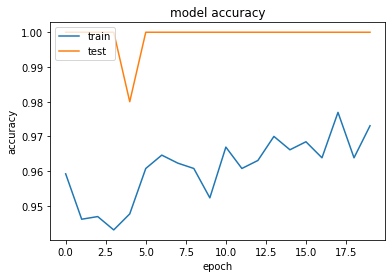

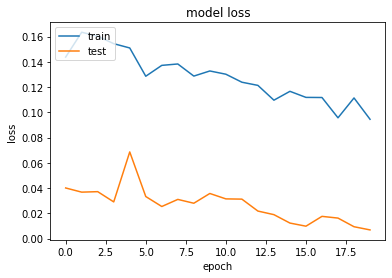

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# HEAT MAPS

In [ ]:
model = tf.keras.models.load_model('Resnet_Final.h5')

from PIL import Image
import glob
x_test1 = []

## CHANGE PATH HERE ##
for filename in glob.glob('/content/18*.jpg'):
    im=Image.open(filename)
    im1 = cv2.imread(filename)
    x_test1.append(preprocessing_fun(im1))

x_test1 = np.array(x_test1)

y_test1=[]
for ii in range(5):
    for jj in range(10):
        y_test1.append(ii)
y_test1 = keras.utils.to_categorical(y_test1, 5)
np.shape(x_test1)

(2, 224, 224, 3)

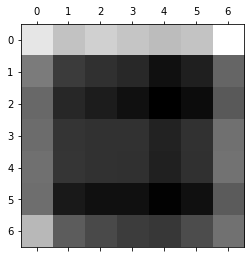

In [ ]:
last_conv_layer_name = "conv5_block3_out"#conv5_block3_3_conv" #conv5_block3_out
img_size = (224,224)
preprocess_input = keras.applications.resnet50.preprocess_input
decode_predictions = keras.applications.resnet50.decode_predictions
#img_array = preprocess_input(get_img_array('/content/3.jpg', size=img_size))

model.layers[-1].activation = None
img_array = x_test1

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
plt.matshow(heatmap, cmap=matplotlib.cm.binary)
plt.show()

In [ ]:
img_with_hm,img = save_and_display_gradcam('/content/15_5_bin.jpg', heatmap)
img_with_hmf,imgf = save_and_display_gradcam('/content/15_4_f_bin.jpg', heatmap)
box_size=[170,150]
imgfinal = cropped_best_image(img_with_hm,img,box_size)
imgfinalf = cropped_best_image(img_with_hmf,imgf,box_size)

 (350, 322, 3)
 (326, 242, 3)
 (350, 322, 3)
 (328, 252, 3)


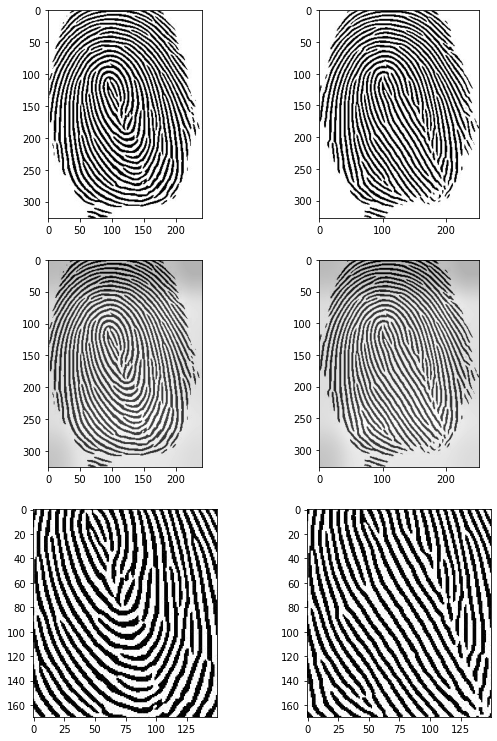

In [ ]:
fig, axs = plt.subplots(3, 2,figsize=(9,13))
axs[0,0].imshow(img,cmap='gray')
axs[0,1].imshow(imgf,cmap='gray')
axs[1,0].imshow(img_with_hm,cmap='gray')
axs[1,1].imshow(img_with_hmf,cmap='gray')
axs[2,0].imshow(imgfinal,cmap='gray')
axs[2,1].imshow(imgfinalf,cmap='gray')

In [ ]:
img_with_hm,img = save_and_display_gradcam('/content/18_3_bin.jpg', heatmap)
img_with_hmf,imgf = save_and_display_gradcam('/content/18_3_af_bin.jpg', heatmap)
box_size=[170,150]
imgfinal = cropped_best_image(img_with_hm,img,box_size)
imgfinalf = cropped_best_image(img_with_hmf,imgf,box_size)

 (350, 322, 3)
 (328, 252, 3)
 (350, 322, 3)
 (302, 235, 3)


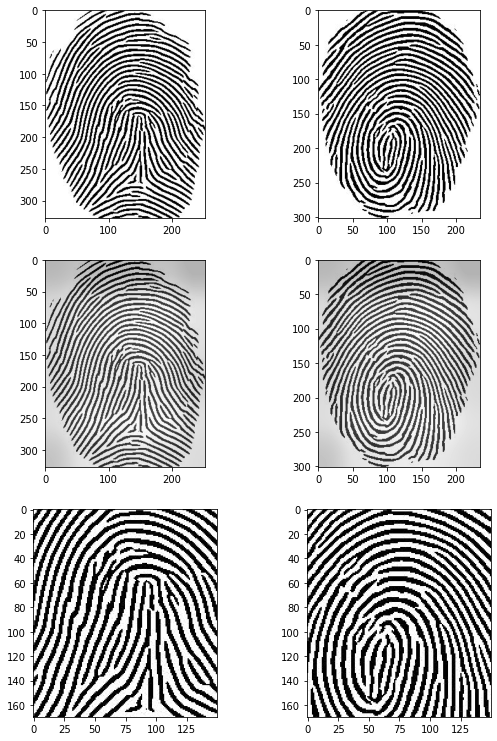

In [ ]:
fig, axs = plt.subplots(3, 2,figsize=(9,13))
axs[0,0].imshow(img,cmap='gray')
axs[0,1].imshow(imgf,cmap='gray')
axs[1,0].imshow(img_with_hm,cmap='gray')
axs[1,1].imshow(img_with_hmf,cmap='gray')
axs[2,0].imshow(imgfinal,cmap='gray')
axs[2,1].imshow(imgfinalf,cmap='gray')

In [1]:
!pip install MinutiaeClassificator

     |████████████████████████████████| 312 kB 8.3 MB/s 
     |████████████████████████████████| 92.6 MB 92 kB/s 
     |████████████████████████████████| 345.0 MB 3.1 kB/s 
     |████████████████████████████████| 50 kB 5.7 MB/s 
     |████████████████████████████████| 367 kB 45.2 MB/s 
     |████████████████████████████████| 3.2 MB 45.0 MB/s 
  Created wheel for MinutiaeClassificator: filename=MinutiaeClassificator-1.0.0-py3-none-any.whl size=48313 sha256=0ce1970c0469101b9d9256406bfe430ba9b840d6eeb189e876579af65690ed4d
  Stored in directory: /root/.cache/pip/wheels/62/fd/95/e84b514a3ef54b62bf67be06b1d38b9cf44491f8c97c407e6f
Successfully built MinutiaeClassificator
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7

In [4]:
from MinutiaeClassificator.MinutiaeClassificatorWrapper import MinutiaeClassificator
minutiaeClassificator = MinutiaeClassificator()
minutiaeClassificator.get_extracted_minutiae("3_1_bin.jpg")
#img = 

SyntaxError: ignored

In [5]:
!pip install fingerprint-feature-extractor

     |████████████████████████████████| 14.6 MB 4.6 MB/s 
  Created wheel for fingerprint-feature-extractor: filename=fingerprint_feature_extractor-0.0.7-py3-none-any.whl size=3894 sha256=446a12ea64f67c70bc19266fc82ed1a2b77d96dd3092644cb497861132ef9659
  Stored in directory: /root/.cache/pip/wheels/e2/12/af/1401be845e969531a2e9dcda23aa2d62741403a39607f2305e
Successfully built fingerprint-feature-extractor
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.6 requires tensorflow>=2.0.0, but you have tensorflow 1.13.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 

In [13]:
#Python
%matplotlib inline
import fingerprint_feature_extractor
import cv2
import matplotlib.pyplot as plt

#from google.colab.patches import cv2_imshow

img = cv2.imread('3_1_bin.jpg', 0)				# read the input image --> You can enhance the fingerprint image using the "fingerprint_enhancer" library
FeaturesTerminations, FeaturesBifurcations = fingerprint_feature_extractor.extract_minutiae_features(img, showResult=False, spuriousMinutiaeThresh=10)

In [ ]:
#plt.plot(FeaturesBifurcations)